In [1]:
import sklearn
import numpy as np
import shap
import pandas as pd

df4 = pd.read_csv("heart.csv")

training_set = df4.dropna(axis=0,how="any")
training_set.reset_index(drop = True, inplace=True)

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index, test_index in split.split(training_set,training_set["output"]):
    strat_train_set = training_set.loc[train_index]
    strat_test_set = training_set.loc[test_index]

strat_train_set.reset_index(drop=True,inplace=True)
strat_test_set.reset_index(drop=True,inplace=True)

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True,with_std=True)
scaler.fit(strat_train_set.iloc[:,0:13])
scaled_training_values = scaler.transform(strat_train_set.iloc[:,0:13])
scaled_test_values = scaler.transform(strat_test_set.iloc[:,0:13])
scaled_train_set = strat_train_set.copy()
scaled_test_set = strat_test_set.copy()

temporary = pd.DataFrame(data=scaled_training_values)
temporary2 = pd.DataFrame(data=scaled_test_values) #we create temporary data frames from the numpy arrays we've just created
#print(temporary)
for i in range(0,13):
    scaled_train_set[scaled_train_set.columns[i]] = temporary[temporary.columns[i]]
    scaled_test_set[scaled_test_set.columns[i]] = temporary2[temporary2.columns[i]]
    
scaler2 = StandardScaler(with_mean=True,with_std=True)
scaler2.fit(strat_train_set.iloc[:,0:13])
scaled_total_values = scaler2.transform(training_set.iloc[:,0:13])
scaled_total_set = training_set.copy()

temporary3 = pd.DataFrame(data=scaled_total_values)
for i in range(0,13):
    scaled_total_set[scaled_total_set.columns[i]] = temporary3[temporary3.columns[i]]

In [4]:
#Begin by creating numpy arrays for our input X and output Y:

X = np.array([scaled_train_set.iloc[:,0:13]])
Y = np.array([scaled_train_set.iloc[:,13]])
#X = np.array([scaled_total_set.iloc[:,0:4]])
#Y = np.array([scaled_total_set.iloc[:,4]])
#X = np.transpose(X)
#Y = np.transpose(Y)


X = np.reshape(X,(242,13)) #Reshape to go from 3d matrix to 2d
Y = np.reshape(Y,(242,1)) # ^

#Now generate a kernel:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
import GPy

kernel = GPy.kern.RBF(input_dim=4, variance=100., lengthscale=100.)
m_gpy = GPy.models.GPClassification(X,Y,kernel)
m_gpy.optimize(messages=True)
#m_gpy.optimize_restarts(num_restarts = 10)

 C:\Users\jacob\Anaconda3\lib\site-packages\GPy\core\gp.py:85: UserWarning:Your kernel has a different input dimension 4 then the given X dimension 13. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


In [5]:
#We shall request values for the variance and lengthscale:

m_var = input("What is the rbf.variance?")
m_length = input("What is the rbf.lengthscale?")

m_var = float(m_var)
m_length = float(m_length)

What is the rbf.variance?1.6266
What is the rbf.lengthscale?3.365


In [6]:
#Instantiate this model in scikit learn


sci_kernel = m_var * RBF(m_length)
gpc = GaussianProcessClassifier(kernel=sci_kernel,optimizer=None).fit(X, Y)

 C:\Users\jacob\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [7]:
X_train = np.array(scaled_train_set.iloc[:,0:13])
#X_train = np.transpose(X_train)
y_train = np.array(scaled_train_set.iloc[:,13])
#y_train = np.transpose(y_train)

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)


for train_index, test_index in skfolds.split(X_train,y_train):
    clone_gpc = clone(gpc)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train[test_index]
    
    clone_gpc.fit(X_train_folds,y_train_folds)
    y_pred = clone_gpc.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

X_test = np.array(scaled_test_set.iloc[:,0:13])
y_test = np.array(scaled_test_set.iloc[:,13])

y_pred = gpc.predict(X_test)

0.8367346938775511
0.8979591836734694
0.6458333333333334
0.8541666666666666
0.875


  0%|          | 0/61 [00:00<?, ?it/s]

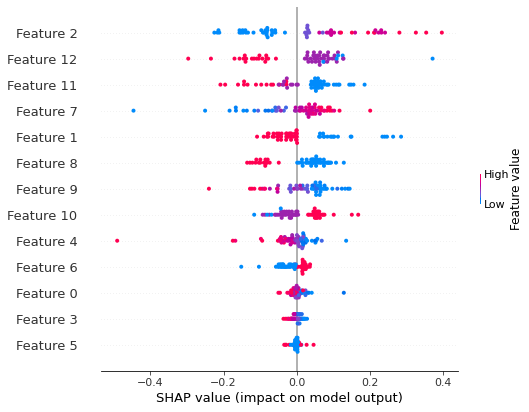

In [10]:
import sklearn
#from sklearn.model_selection import train_test_split
import numpy as np
import shap
#import time
#from sklearn.gaussian_process import GaussianProcessRegressor
#from sklearn.gaussian_process.kernels import WhiteKernel, DotProduct

#X,y = shap.datasets.diabetes()
#X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_summary = shap.kmeans(scaled_total_set.iloc[:,0:13], 10)
#kernel = DotProduct() + WhiteKernel()

#gp = GaussianProcessRegressor(kernel)
#gp.fit(X_train, y_train)

explainer = shap.KernelExplainer(gpc.predict, X_train_summary)
shap_values = explainer.shap_values(X_test)
plt = shap.summary_plot(shap_values, X_test)

In [12]:
shap_values

array([[-1.59387768e-02, -7.93195215e-02, -1.40647811e-01,
        -2.68860548e-02, -2.62132046e-02,  1.00265385e-03,
        -2.98956910e-02, -1.66348204e-01, -1.35743274e-01,
         1.55738125e-02, -5.19196285e-02, -4.97210251e-02,
         1.25198639e-01],
       [-4.60699135e-02, -6.37046021e-02, -2.25280288e-01,
         6.51665702e-03, -1.03571726e-02,  4.57543512e-02,
         2.99857263e-02,  2.53189823e-02,  1.59213184e-02,
         6.36274628e-02, -7.54932742e-02, -2.08702879e-01,
        -1.38374455e-01],
       [ 5.07099574e-03, -4.14858282e-02, -8.25699997e-02,
        -8.79426027e-03, -3.11580221e-02,  5.51433674e-04,
         3.11105092e-03, -7.75697098e-02, -8.62842670e-02,
        -5.26361490e-02, -4.19971751e-02, -6.49627215e-02,
        -1.02133433e-01],
       [-9.11086557e-03, -1.58033803e-02,  2.14567361e-01,
        -2.75060388e-03,  5.60540553e-02, -1.66131741e-03,
        -2.25930323e-02,  3.21048362e-02,  4.54857604e-02,
        -1.00387004e-01, -1.94947179e

In [9]:
scaled_total_set

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,0.953621,0.68313,2.044420,0.740279,-0.248894,2.473388,-1.028992,-0.005652,-0.715891,1.020217,-2.283657,-0.714691,-2.217514,1
1,-1.892766,0.68313,1.050947,-0.095037,0.107139,-0.404304,0.857493,1.681343,-0.715891,2.017091,-2.283657,-0.714691,-0.561223,1
2,-1.454861,-1.46385,0.057474,-0.095037,-0.856244,-0.404304,-1.028992,0.997426,-0.715891,0.272561,0.948185,-0.714691,-0.561223,1
3,0.187286,0.68313,0.057474,-0.651915,-0.186065,-0.404304,0.857493,1.270992,-0.715891,-0.225876,0.948185,-0.714691,-0.561223,1
4,0.296763,-1.46385,-0.936000,-0.651915,2.285221,-0.404304,0.857493,0.587076,1.396861,-0.392021,0.948185,-0.714691,-0.561223,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0.296763,-1.46385,-0.936000,0.461840,-0.081349,-0.404304,0.857493,-1.236702,1.396861,-0.724313,-0.667736,-0.714691,1.095069,0
299,-1.016955,0.68313,2.044420,-1.208792,0.400342,-0.404304,0.857493,-0.826352,-0.715891,0.106416,-0.667736,-0.714691,1.095069,0
300,1.501003,0.68313,-0.936000,0.684591,-1.086618,2.473388,0.857493,-0.416002,-0.715891,1.934018,-0.667736,1.207034,1.095069,0
301,0.296763,0.68313,-0.936000,-0.095037,-2.385090,-0.404304,0.857493,-1.601458,1.396861,0.106416,-0.667736,0.246171,1.095069,0
